In [1]:
import sys
sys.path.append("../../XLEMOO")

In [2]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier

In [3]:
def plot_mean_fitness(population, fitness_fun):
    fitness = np.squeeze([fitness_fun(p) for p in population])
    means = np.mean(fitness, axis=1)
    plt.plot(np.arange(means.shape[0]), means)
    
def plot_std_fitness(population, fitness_fun):
    fitness = np.squeeze([fitness_fun(p) for p in population])
    stds = np.std(fitness, axis=1)
    plt.plot(np.arange(stds.shape[0]), stds)
    
def plot_best_fitness(population, fitness_fun):
    fitness = np.squeeze([fitness_fun(p) for p in population])
    mins = np.min(fitness, axis=1)
    plt.plot(np.arange(mins.shape[0]), mins)

## Define problem

In [4]:
n_objectives = 4
n_variables = 5
problem = test_problem_builder("DTLZ2", n_variables, n_objectives)
# problem = river_pollution_problem()

## Setting model parameters

In [5]:
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
#ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
#nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
ref_point = np.array([0.2, 0.6, 0.3, 0.22])
fitness_fun = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = naive_sum

lem_params = LEMParams(
    n_total_iterations=100,
    n_ea_gen_per_iter=10,
    n_ml_gen_per_iter=1,
    use_ea=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    past_gens_to_consider=1
)

ea_params = EAParams(
    population_size=128,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    selection_op=TournamentSelection(None, tournament_size=4),
    population_init_design="LHSDesign"
)

# ml = DecisionTreeClassifier(random_state=0)
ml = DecisionTreeClassifier()
ml_params = MLParams(
    H_split=0.2,
    L_split=0.2,
    ml_model=ml,
    ml_fitness=fitness_fun
)

## Setup LEMOO model

In [6]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [7]:
lemoo.reset_population()
history = lemoo.run()[3:]

starting learning mode
Cherry pick results: EA: 124; ML: 4.
starting learning mode
Cherry pick results: EA: 123; ML: 5.
starting learning mode
Cherry pick results: EA: 127; ML: 1.
starting learning mode
Cherry pick results: EA: 126; ML: 2.
starting learning mode
Cherry pick results: EA: 124; ML: 4.
starting learning mode
Cherry pick results: EA: 125; ML: 3.
starting learning mode
Cherry pick results: EA: 125; ML: 3.
starting learning mode
Cherry pick results: EA: 125; ML: 3.
starting learning mode
Cherry pick results: EA: 126; ML: 2.
starting learning mode
Cherry pick results: EA: 124; ML: 4.
starting learning mode
Cherry pick results: EA: 124; ML: 4.
starting learning mode
Cherry pick results: EA: 126; ML: 2.
starting learning mode
Cherry pick results: EA: 126; ML: 2.
starting learning mode
Cherry pick results: EA: 124; ML: 4.
starting learning mode
Cherry pick results: EA: 125; ML: 3.
starting learning mode
Cherry pick results: EA: 125; ML: 3.
starting learning mode
Cherry pick resul

In [8]:
objectives = np.array([p.objectives for p in history])

[0.2  0.6  0.3  0.22]


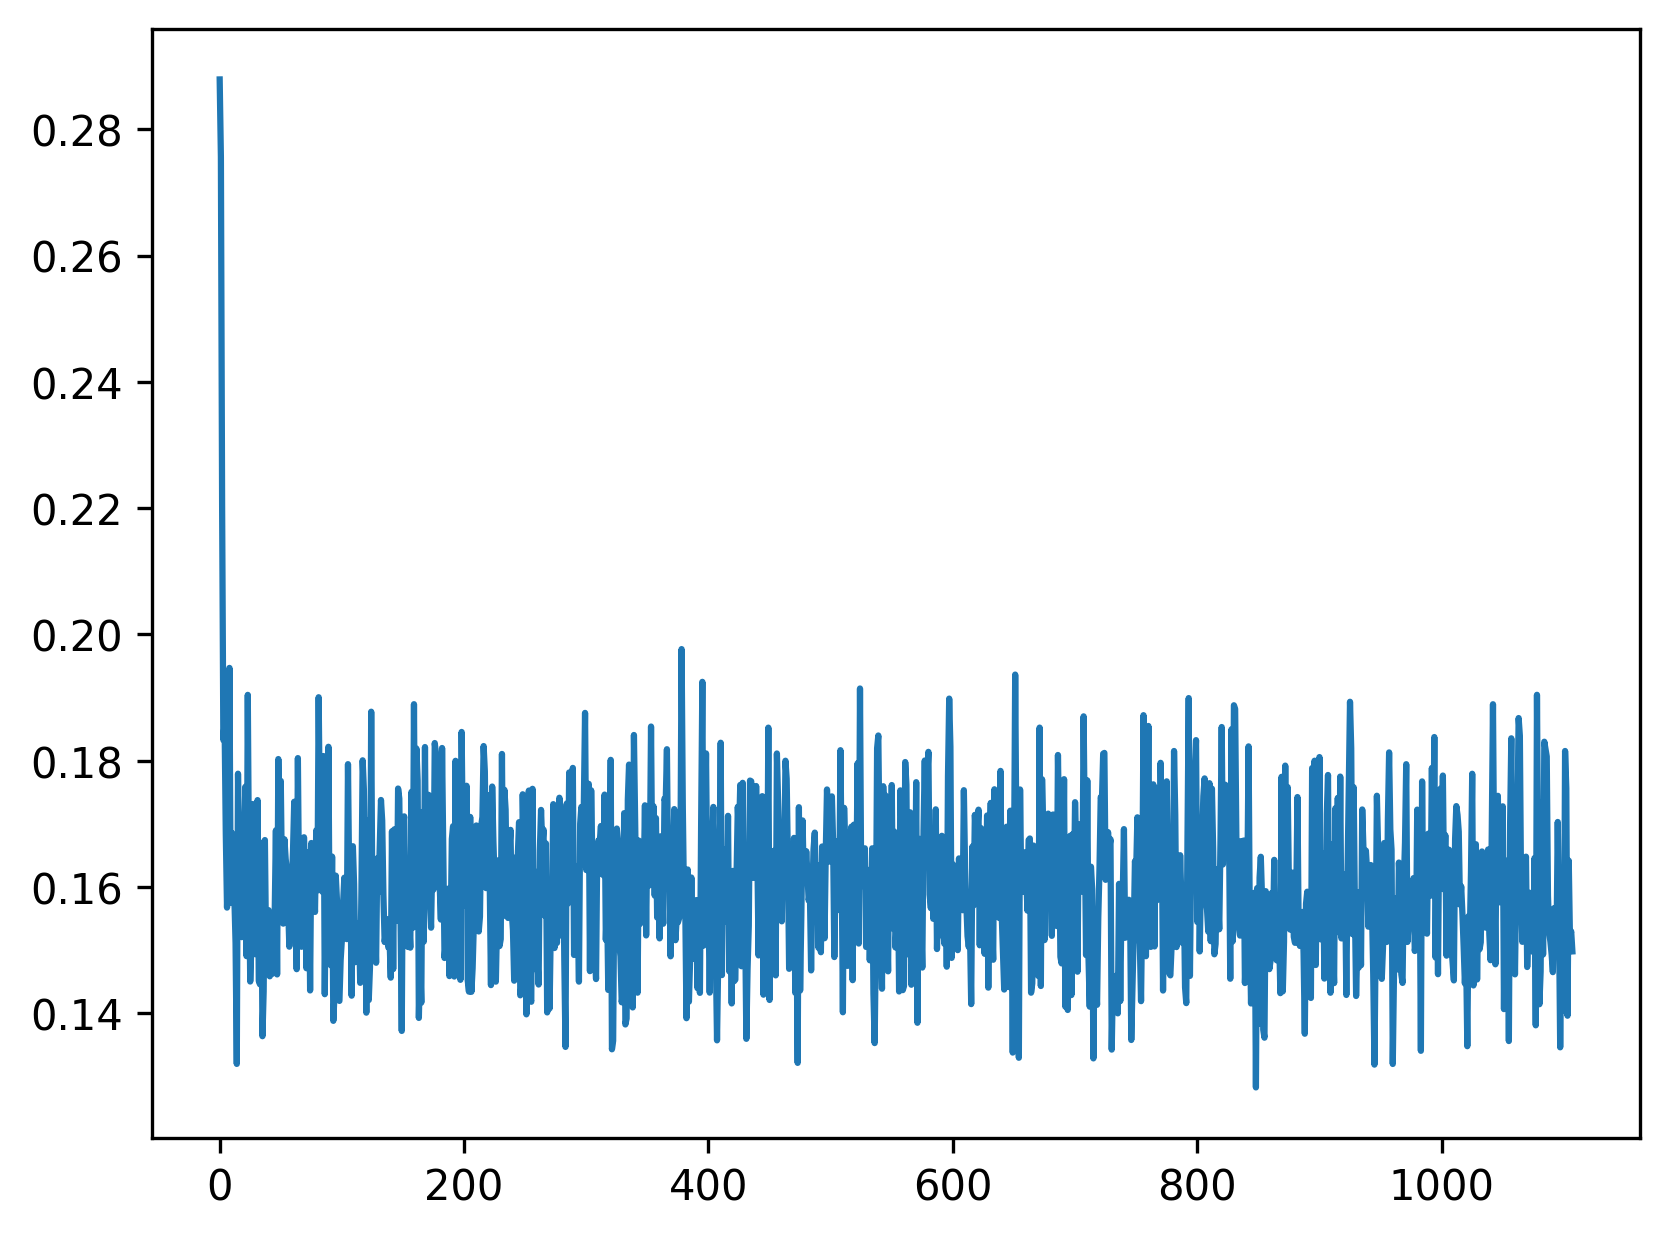

In [9]:
def plot_hypervolume(population, ref_point):
    objectives = np.array([p.problem.evaluate(p.individuals).objectives for p in population])
    hvs = np.array([hypervolume_indicator(objs, nadir) for objs in objectives])
    plt.plot(np.arange(hvs.shape[0]), hvs)
                       
plot_hypervolume(history, ref_point)
print(ref_point)

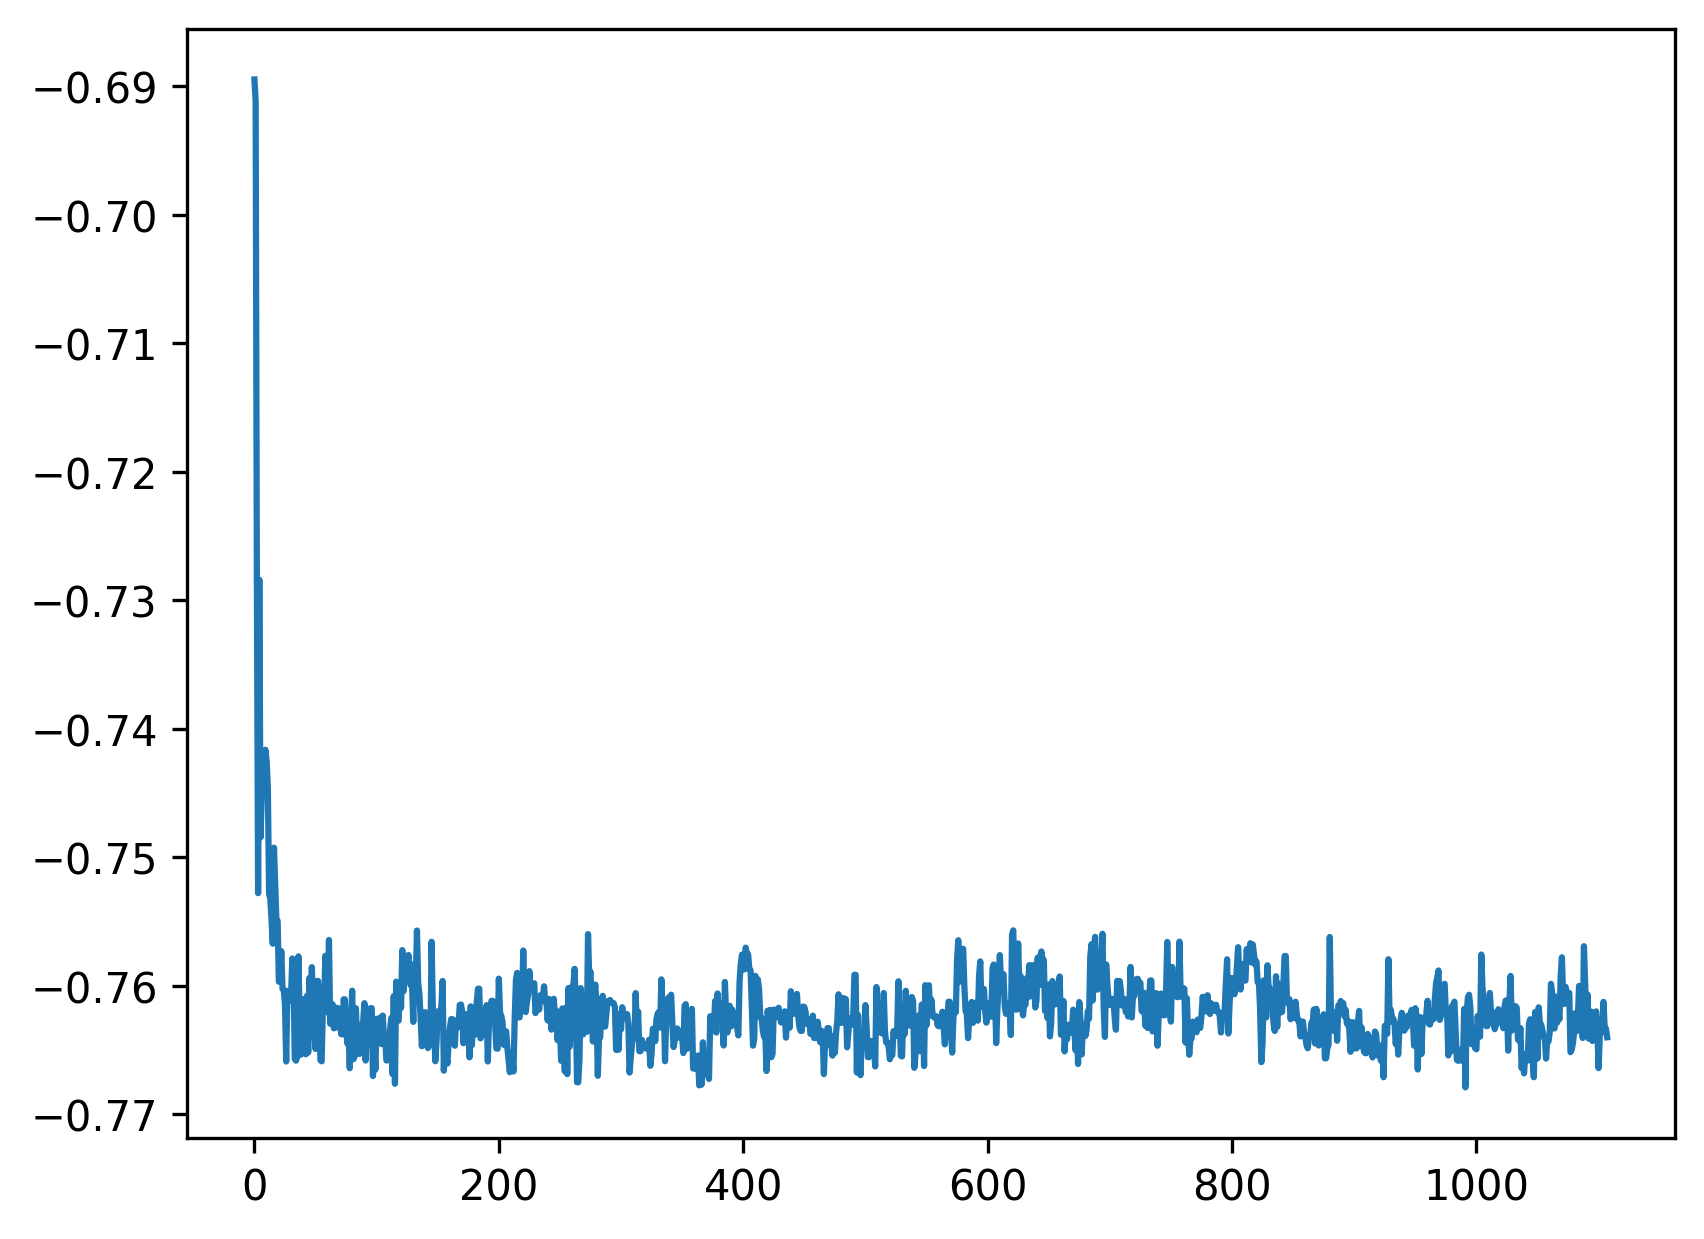

In [10]:
plot_best_fitness(history, fitness_fun)

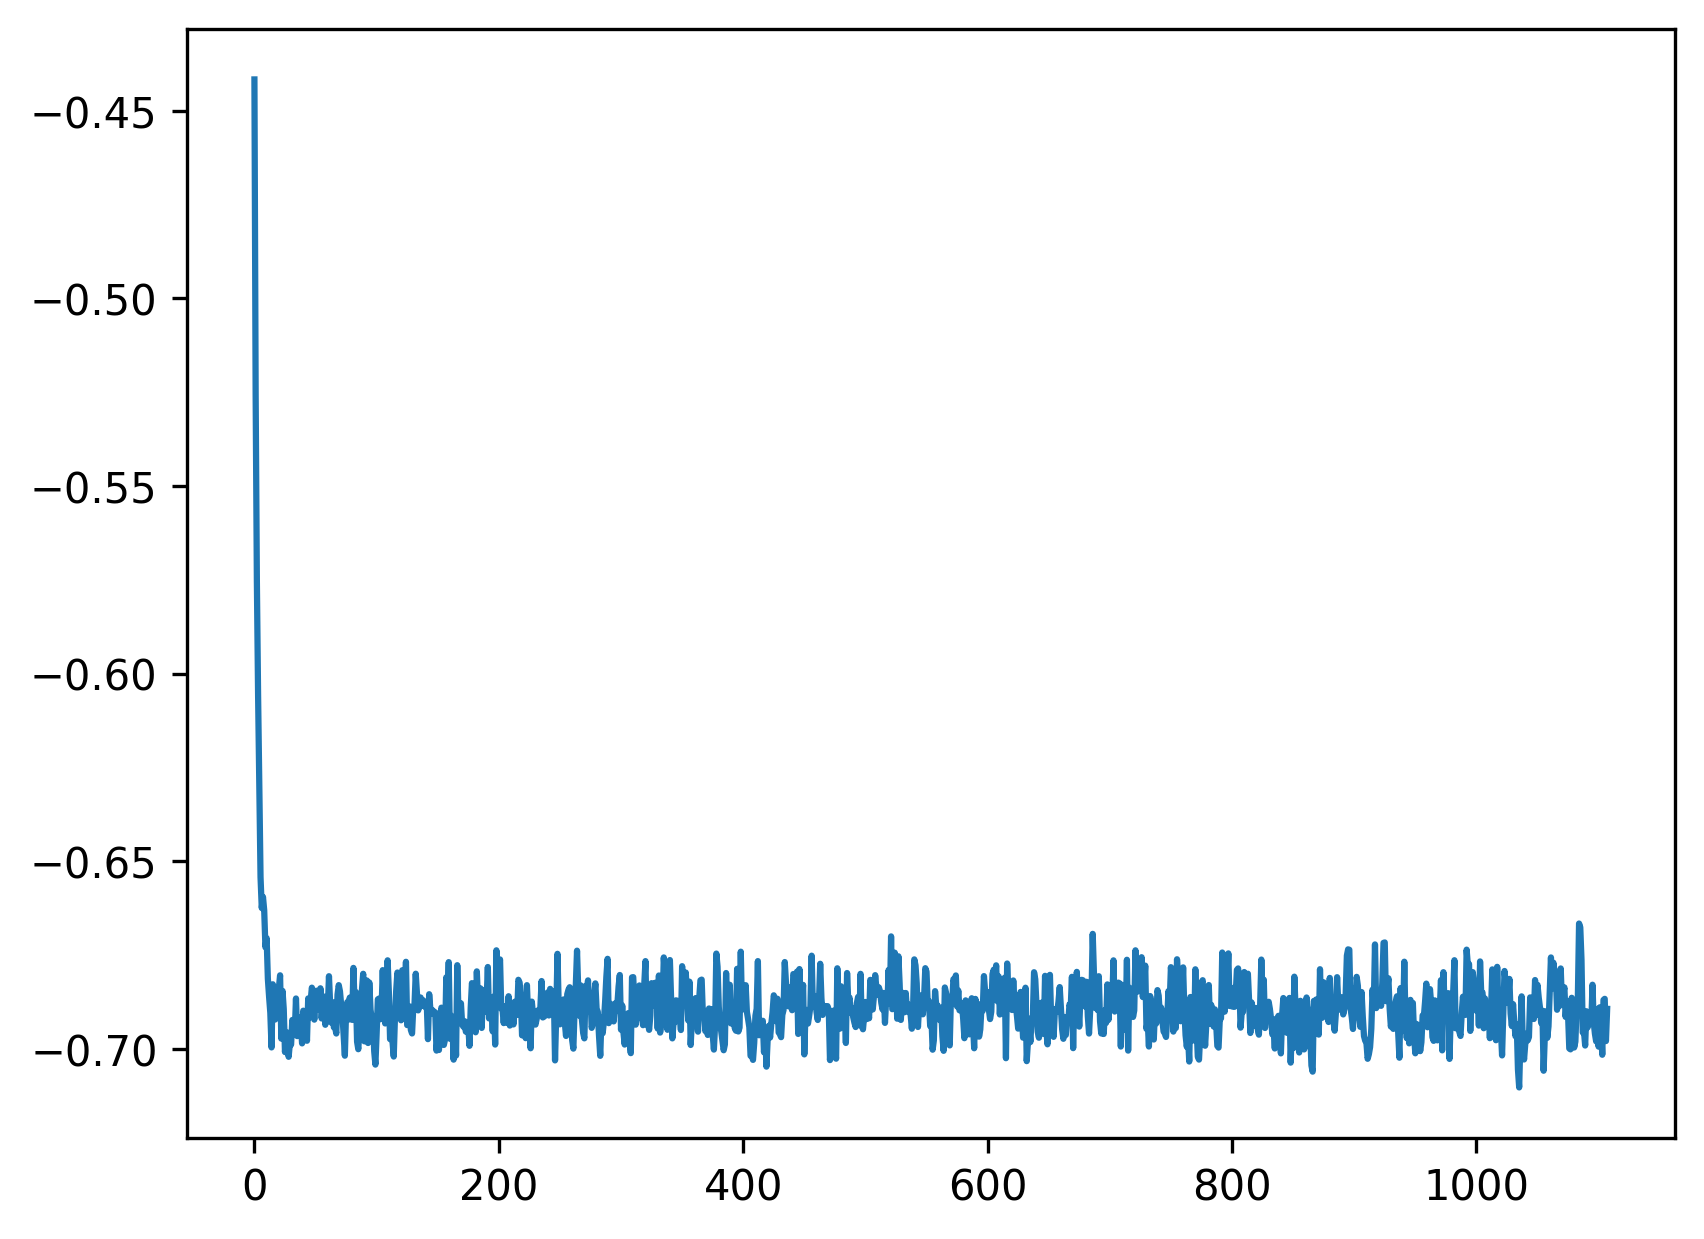

In [11]:
plot_mean_fitness(history, fitness_fun)

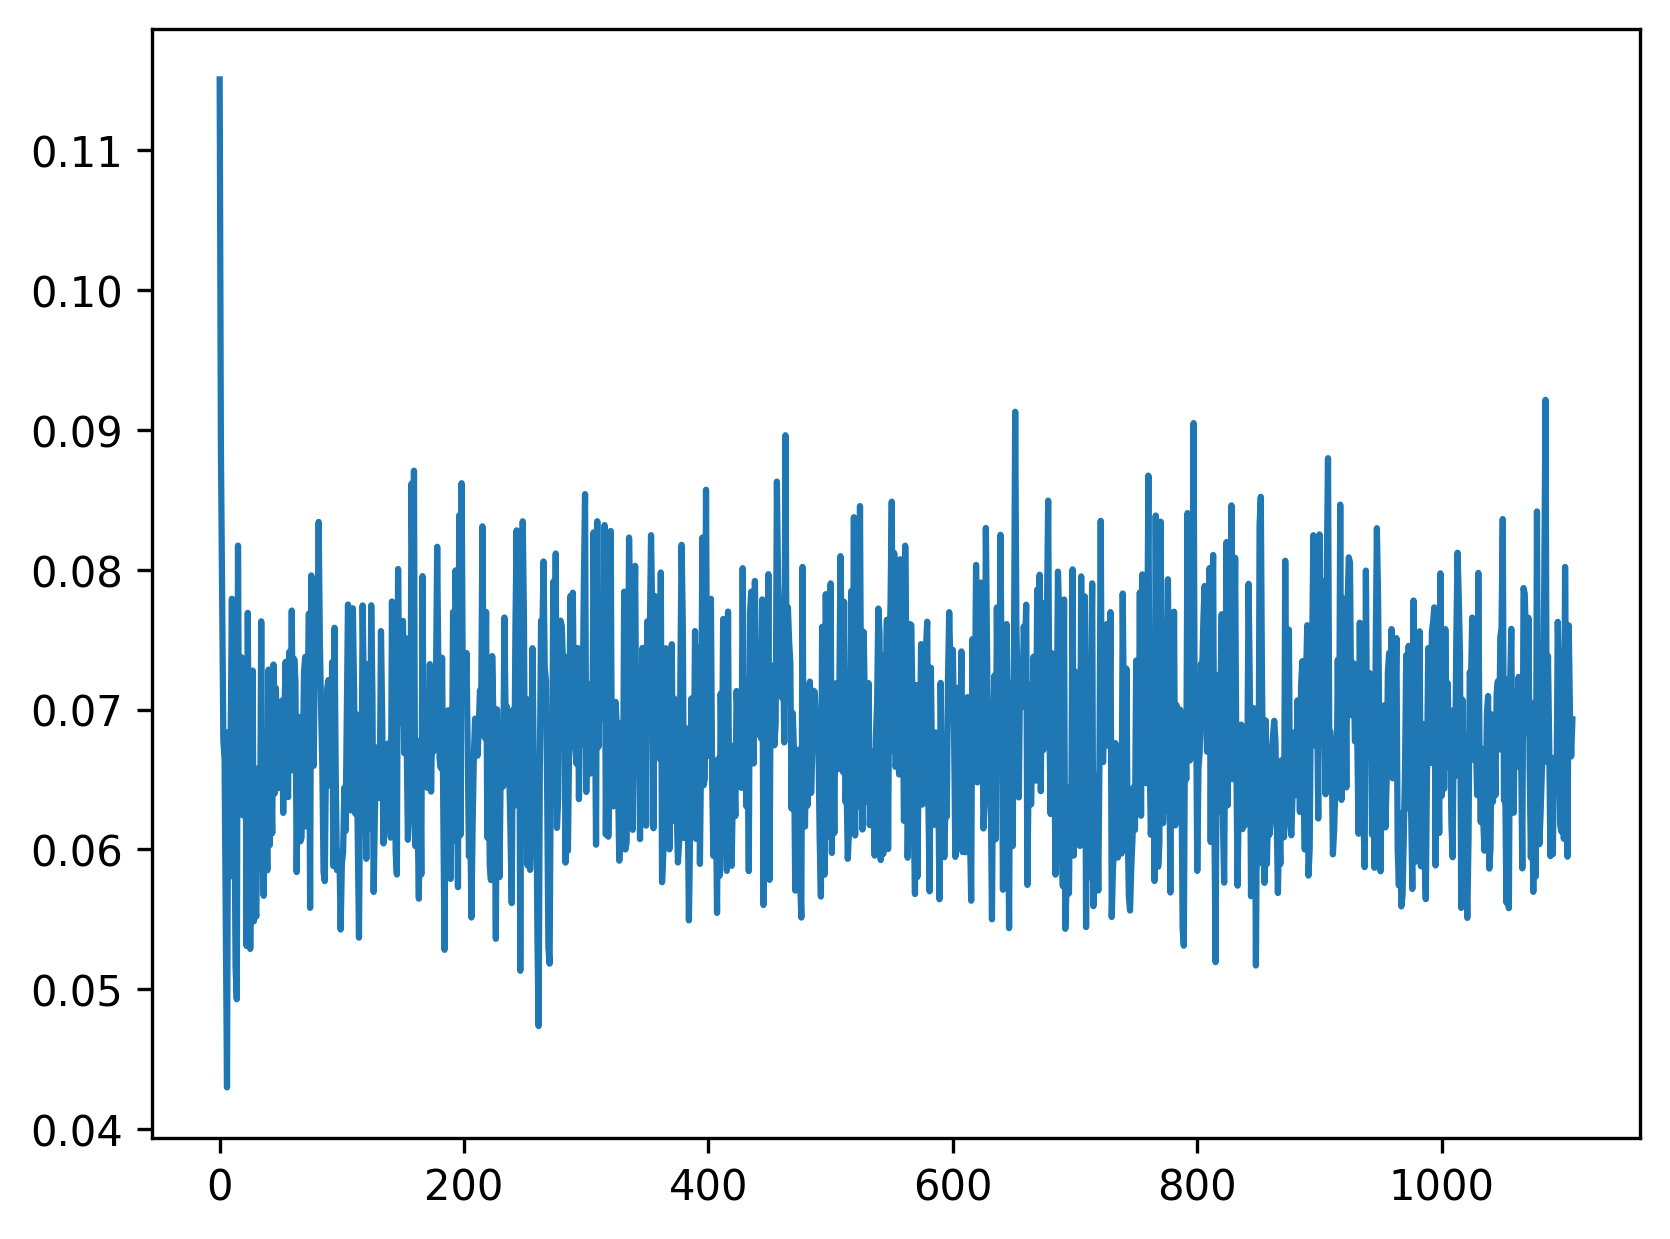

In [12]:
plot_std_fitness(history, fitness_fun)

{'rules': [[1, 'lte', 0.3249836564064026]], 'samples': 11.0, 'impurity': 0.0, 'classification': -1}
{'rules': [[1, 'gt', 0.3249836564064026], [1, 'lte', 0.34556378424167633], [3, 'lte', 0.5566254556179047], [0, 'lte', 0.31657928228378296]], 'samples': 24.0, 'impurity': 0.0, 'classification': 1}
{'rules': [[1, 'gt', 0.3249836564064026], [1, 'lte', 0.34556378424167633], [3, 'lte', 0.5566254556179047], [0, 'gt', 0.31657928228378296]], 'samples': 1.0, 'impurity': 0.0, 'classification': -1}
{'rules': [[1, 'gt', 0.3249836564064026], [1, 'lte', 0.34556378424167633], [3, 'gt', 0.5566254556179047], [4, 'lte', 0.4552394449710846]], 'samples': 1.0, 'impurity': 0.0, 'classification': 1}
{'rules': [[1, 'gt', 0.3249836564064026], [1, 'lte', 0.34556378424167633], [3, 'gt', 0.5566254556179047], [4, 'gt', 0.4552394449710846]], 'samples': 4.0, 'impurity': 0.0, 'classification': -1}
{'rules': [[1, 'gt', 0.3249836564064026], [1, 'gt', 0.34556378424167633]], 'samples': 9.0, 'impurity': 0.0, 'classification

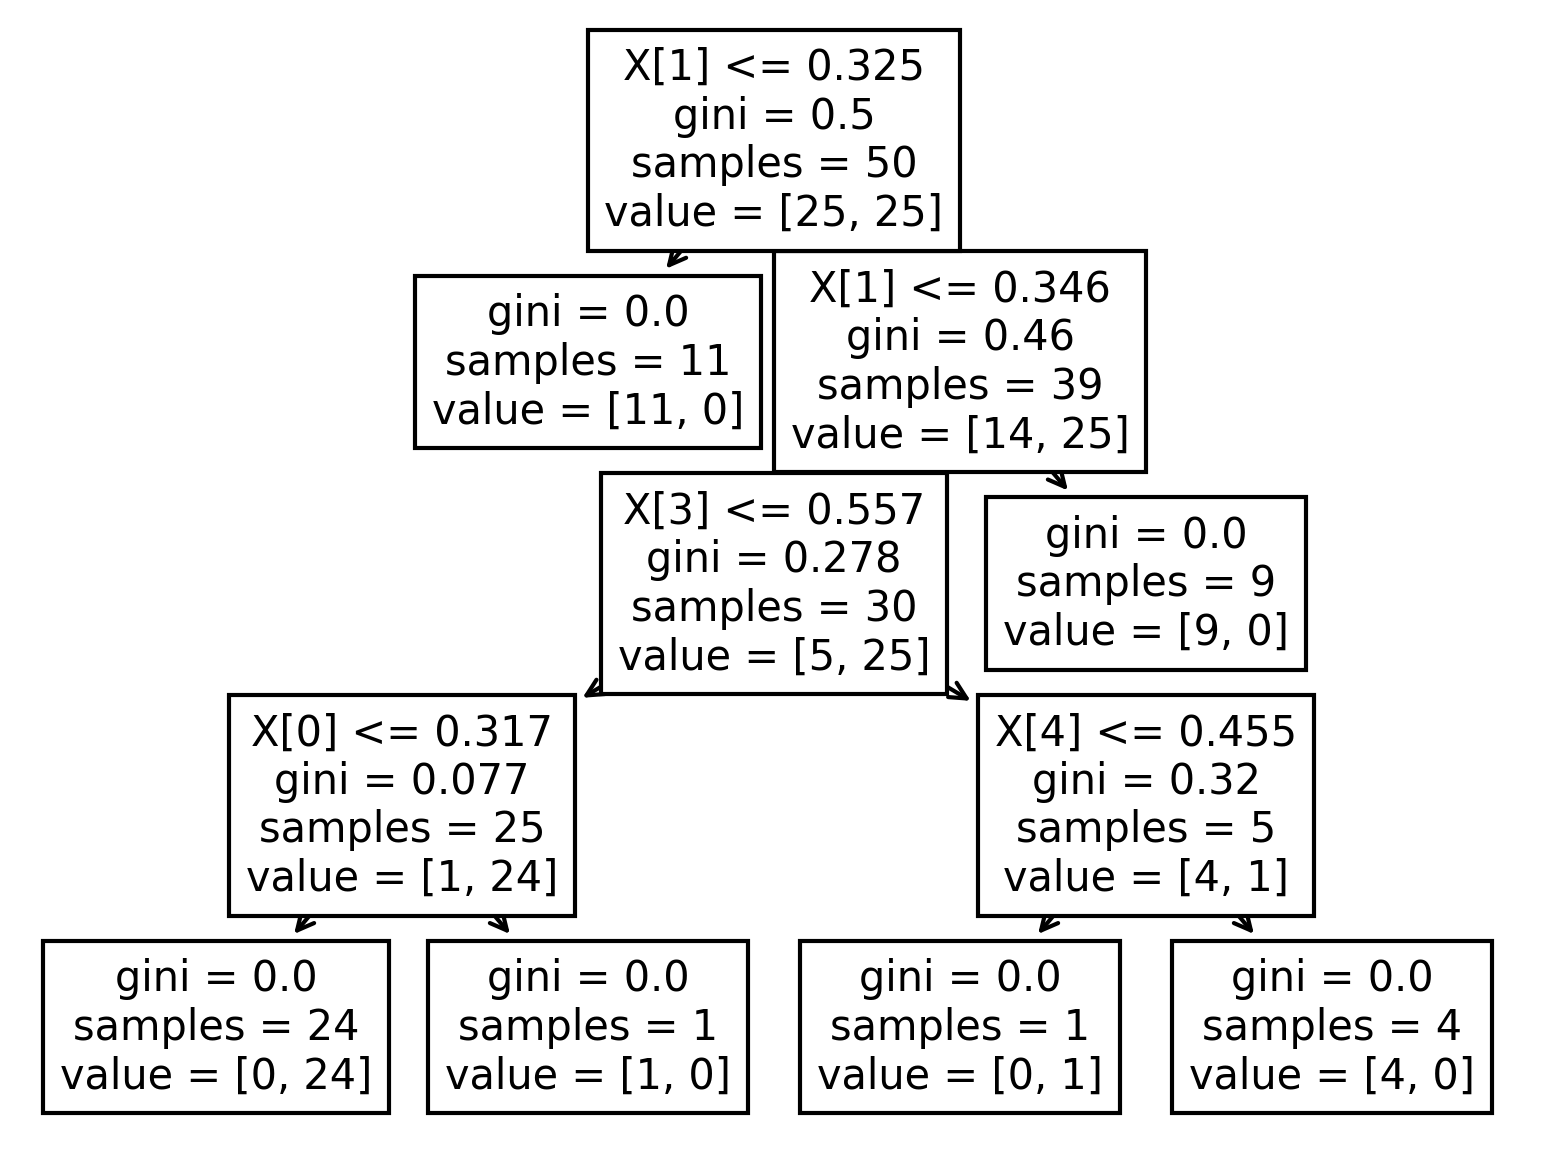

In [13]:
tree.plot_tree(lemoo.current_ml_model);
paths = find_all_paths(lemoo.current_ml_model)
for p in paths:
    print(p)

In [135]:
print(history[-1].individuals)

[[0.26193015 0.33591047 0.67719064 0.50211091 0.49565384]
 [0.26192999 0.33590908 0.67721119 0.49858845 0.49639348]
 [0.26193971 0.33590941 0.67721129 0.51924905 0.49820436]
 [0.26192986 0.33591008 0.67721192 0.43077873 0.50510278]
 [0.26193987 0.33591215 0.67721111 0.49867331 0.40335367]
 [0.26193102 0.33136743 0.59039921 0.49908348 0.49831454]
 [0.26193218 0.41214497 0.67721106 0.49903308 0.49834887]
 [0.2619448  0.33591209 0.67721117 0.49916205 0.4985696 ]
 [0.26193277 0.33590959 0.67721105 0.49924143 0.498793  ]
 [0.26193675 0.36752076 0.67719031 0.50089859 0.49858024]
 [0.26193656 0.33591037 0.7149716  0.49917529 0.49911894]
 [0.26193265 0.33590899 0.67721124 0.49916165 0.53359331]
 [0.22147489 0.33591039 0.67721123 0.49913202 0.71245126]
 [0.26193329 0.33591075 0.67719093 0.50248421 0.50158586]
 [0.26194463 0.35095607 0.67719197 0.46018306 0.56014246]
 [0.28084824 0.3359159  0.67721093 0.49883359 0.49690905]
 [0.2356594  0.38103503 0.65936037 0.47672214 0.49831865]
 [0.24770819 0